#### Imports 

In [1]:
from matplotlib import pyplot as plt


plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
import bbox_visualizer as bbv
from PIL import Image
import logging
import boto3
import json
import cv2
import os

##### Setup logger

In [3]:
logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

#### Explore test images 

Test image: 5.png


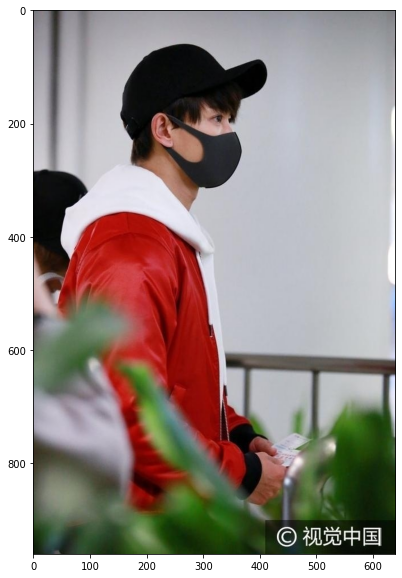

Test image: 1.png


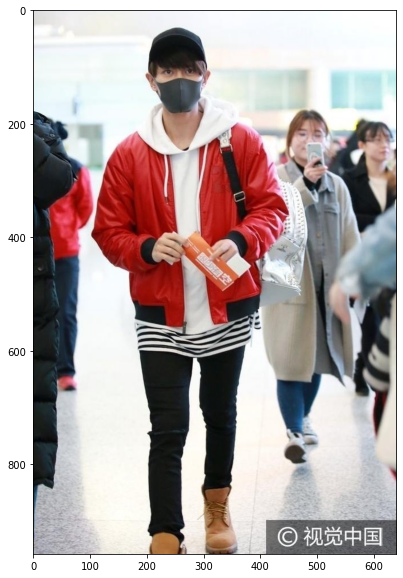

Test image: 3.png


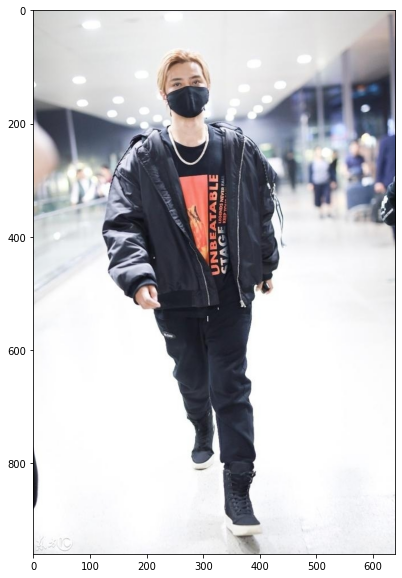

Test image: 2.png


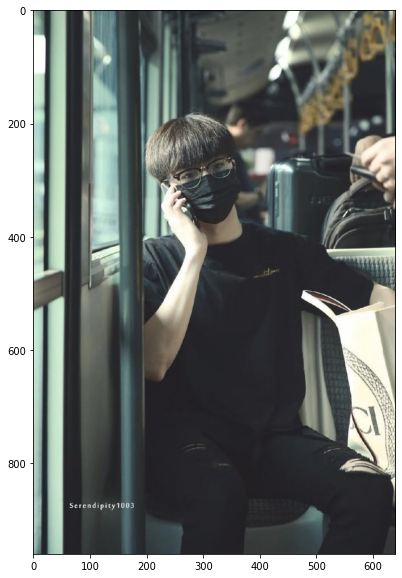

Test image: 4.png


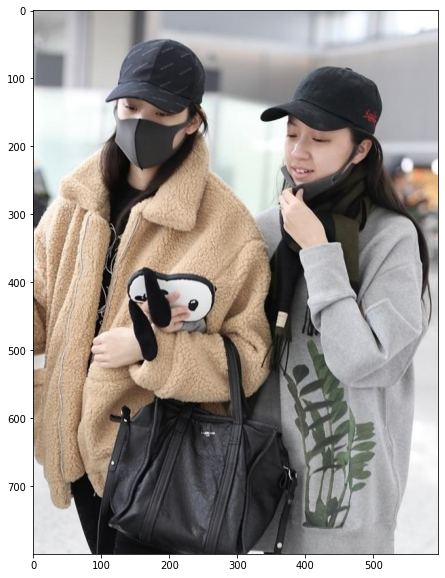

In [4]:
for root, _, files in os.walk('./test'):
    for file_ in files:
        image_path = f'{root}/{file_}'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        logger.info(f'Test image: {file_}')
        plt.imshow(image)
        plt.show()

#### Invoke SageMaker endpoint for inference (Mask detection)

In [ ]:
def invoke_endpoint(image):
    # Replace endpoint_name below with the one you create
    endpoint_name = 'jumpstart-ftc-mx-od-ssd-512-mobilenet1-0-coco-1'
    sagemaker = boto3.client('runtime.sagemaker')
    response = sagemaker.invoke_endpoint(EndpointName=endpoint_name, 
                                         ContentType='application/x-image', 
                                         Body=image)
    predictions = json.loads(response['Body'].read())
    return predictions

In [ ]:
def normalize(bboxes, image):
    normalized_bboxes = []
    for bbox in bboxes:
        x, y, w, h = bbox
        dw, dh = image.size
        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)

        if l < 0:
            l = 0
            
        if r > dw - 1:
            r = dw - 1
            
        if t < 0:
            t = 0
            
        if b > dh - 1:
            b = dh - 1
            
        x1, x2, y1, y2 = l, r, t, b
        normalized_bboxes.append([x1, y1, x2, y2])
    return normalized_bboxes

In [ ]:
for i in range(1, 76):
    with open(f'./data/images/{i}.png', 'rb') as file: 
        print(f'{i}.png')
        input_img = file.read()
        best_results_per_input = query_endpoint(input_img)  
        bboxes, classes, confidences = best_results_per_input
        hc_bboxes = []
        for j, bbox in enumerate(bboxes):
            if confidences[j] > 0.9:
                hc_bboxes.append(bbox)
        bboxes = transform(hc_bboxes)
        img = cv2.imread(f'./data/images/{i}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = bbv.draw_multiple_rectangles(img, bboxes)
        plt.imshow(img)
        plt.show()


### Display model predictions as bounding boxes on the input image 